<a href="https://colab.research.google.com/github/cu2mauro/NN_matlab_bubble/blob/trials/ColabCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network to classify MATLAB bubble results

The problem is to understand how the result $y$ of the 2D integration of a nonlinear function $f$ depends on the boundary of the integration domain $\Omega$, described as a 2D Bspline-curve $\partial\Omega$:
$$y[X]=\int_{\Omega[X]} f(z,\rho)dzd\rho.$$
The input $X$ of the NN is the vector of coefficients of the said curve, while the output is the result of the integral. Many integration with random (but plausible) coefficients are performed in MATLAB and their results are used as a training set.

To build, train and test the CNN we use keras with the tensorflow backend.
Below we import the necessary modules.

In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import scipy
import scipy.io as sio
from scipy import interpolate
from scipy.interpolate import BSpline, make_interp_spline
import sys
%matplotlib inline
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import backend as K
from os.path import dirname, join as pjoin

Load dataset: vectors of control points in X, actions in y.

In [3]:
from google.colab import drive
drive.mount('/content/drive');

Mounted at /content/drive


In [4]:
mat = sio.loadmat('/content/drive/MyDrive/NN/NNtotNew')
data = mat['results']
X = np.reshape(np.vstack(data[:,0][:]),(len(data),12))
y = 2/np.pi * np.arctan(np.vstack(data[:,3][:])) #normalized with 2/pi arctan
X = np.expand_dims(np.reshape(np.c_[np.zeros(len(y)),X,np.zeros(len(y))],(len(y),2,7)), axis=3) # add zeros for first X and last Y coordinates, reshape

print(X.shape,y.shape)

(4917, 2, 7, 1) (4917, 1)


Divide dataset into training (80%), validation (10%) and test set (10%)



In [5]:
Ntot = len(X)
tot_ind = np.arange(Ntot)
random.shuffle(tot_ind)
val_ind = tot_ind[int(Ntot*0.8):int(Ntot*0.9)]
train_ind = tot_ind[0:int(Ntot*0.8)]
test_ind = tot_ind[int(Ntot*0.9):]
X_train = X[train_ind]
y_train = y[train_ind]
X_val = X[val_ind]
y_val = y[val_ind]
X_test = X[test_ind]
y_test = y[test_ind]

print(X_train.shape)

(3933, 2, 7, 1)


What is our data: show border $\partial\Omega$, spline-curve control points $X$, and corresponding action $y$:

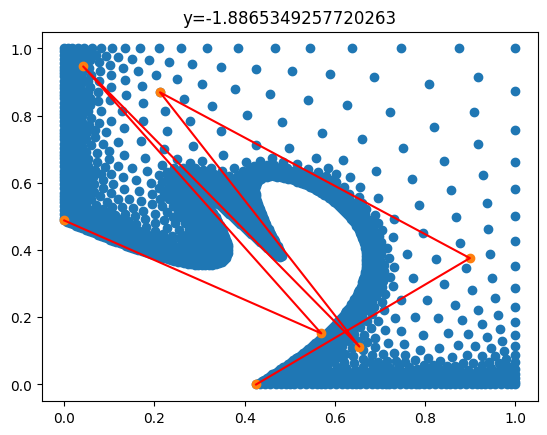

In [6]:
t = np.random.randint(len(X))
plt.scatter(np.transpose(data[t,1]['Points'][0][0])[0],np.transpose(data[t,1]['Points'][0][0])[1])
plt.scatter(X[t][0],X[t][1])
plt.plot(X[t][0],X[t][1],'r')
S = 'y='+str(np.pi/2 * np.tan(y[t][0]))
plt.title(S);
plt.show()

The choice of the CNN architecture was motivated by the importance of the spatial information of the input (control point `X[i,j]` cares about control points `X[i±1,j±1]`).

We now build the CNN, compile and train/validate it:

In [115]:
model_cnn = Sequential()

model_cnn.add(Conv2D(4, (2, 2), input_shape=(2, 7, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.005)))
model_cnn.add(Activation('tanh'))

model_cnn.add(Conv2D(16, (2, 2)))
model_cnn.add(Activation('tanh'))

model_cnn.add(Dropout(0.3))
model_cnn.add(Flatten())

model_cnn.add(Dense(32, kernel_regularizer=keras.regularizers.l2(0.005)))
model_cnn.add(Activation('tanh'))

model_cnn.add(Dense(16))
model_cnn.add(Activation('tanh'))

model_cnn.add(Dense(8))
model_cnn.add(Activation('tanh'))

model_cnn.add(Dense(4))
model_cnn.add(Activation('tanh'))

model_cnn.add(Dense(2))
model_cnn.add(Activation('tanh'))

model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1, activation='tanh'))

In [116]:
model=model_cnn
model.summary()

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['mean_absolute_error'])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 2, 7, 4)           20        
                                                                 
 activation_28 (Activation)  (None, 2, 7, 4)           0         
                                                                 
 conv2d_47 (Conv2D)          (None, 1, 6, 16)          272       
                                                                 
 activation_29 (Activation)  (None, 1, 6, 16)          0         
                                                                 
 dropout_42 (Dropout)        (None, 1, 6, 16)          0         
                                                                 
 flatten_23 (Flatten)        (None, 96)                0         
                                                                 
 dense_78 (Dense)            (None, 32)              

In [117]:
nn_history = model.fit(X_train, y_train,
                        batch_size=265,
                        epochs=2000,
                        verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/2000
15/15 [==============================] - 3s 25ms/step - loss: 0.8685 - mean_absolute_error: 0.6757 - val_loss: 0.7891 - val_mean_absolute_error: 0.6389
Epoch 2/2000
15/15 [==============================] - 0s 10ms/step - loss: 0.8205 - mean_absolute_error: 0.6740 - val_loss: 0.7514 - val_mean_absolute_error: 0.6506
Epoch 3/2000
15/15 [==============================] - 0s 11ms/step - loss: 0.7801 - mean_absolute_error: 0.6625 - val_loss: 0.7212 - val_mean_absolute_error: 0.6399
Epoch 4/2000
15/15 [==============================] - 0s 13ms/step - loss: 0.7571 - mean_absolute_error: 0.6589 - val_loss: 0.6938 - val_mean_absolute_error: 0.6311
Epoch 5/2000
15/15 [==============================] - 0s 11ms/step - loss: 0.7223 - mean_absolute_error: 0.6468 - val_loss: 0.6671 - val_mean_absolute_error: 0.6176
Epoch 6/2000
15/15 [==============================] - 0s 10ms/step - loss: 0.6975 - mean_absolute_error: 0.6330 - val_loss: 0.6447 - val_mean_absolute_error: 0.6155
Epoch 7/20

In [ ]:
plt.plot(nn_history.history['loss'])
plt.plot(nn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

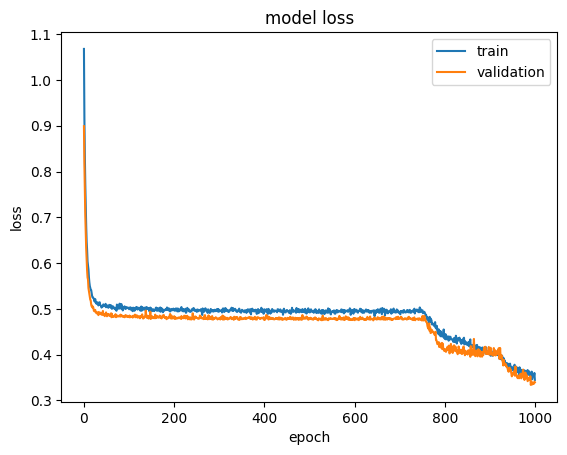

In [110]:
plt.plot(nn_history.history['loss'])
plt.plot(nn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

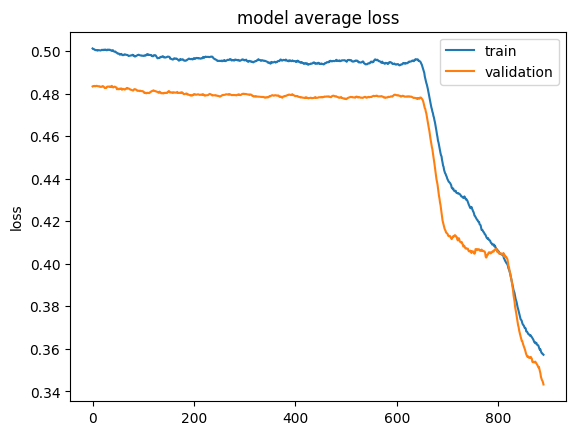

In [111]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

plt.plot(movingaverage(nn_history.history['loss'],20)[100:-10])
plt.plot(movingaverage(nn_history.history['val_loss'],20)[100:-10])
plt.title('model average loss')
plt.ylabel('loss')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [96]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])

Test score: 0.3547108769416809


---

In [88]:
Xn=np.array([[0.    , 0.0518,    0.1000,    0.1414,    0.1732,   0.1932,    0.2000],
 [    0.2000,    0.1932,    0.1732,    0.1414,    0.1000,    0.0518, 0.]])
Xn=np.expand_dims(Xn, axis=2)
Xn=np.expand_dims(Xn, axis=0)

In [89]:
print('The predicted action is y=', np.pi/2 * np.tan(model.predict(Xn,verbose=0))[0][0])

The predicted action is y= 0.13645252521252554
